In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# ift6758/data/milestone2/q3_baseline
import sys
sys.path.append('../ift6758/data/milestone2')
from q3_baseline import read_dataset,\
                        get_prob,\
                        get_percentile,\
                        get_rate,\
                        plot_models

In [18]:
#########################################################
# 5.1 Simple XGboost
#########################################################

def train(X, y, features=['Distance from Net']):
    '''
    reference: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
    '''
    
    X,y = read_dataset()

    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[features],
                                                        y,
                                                        test_size=0.20,
                                                        random_state=50)

    # Fit model no training data
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    # Make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # Evaluate predictions
    accuracy = metrics.accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    


In [19]:
X,y = read_dataset()
train(X,y)

[22:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.39%


In [13]:
train(X,y, features=['Angle from Net'])

[00:54:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.40%


In [13]:
y.shape

(311106, 1)

[22:57:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


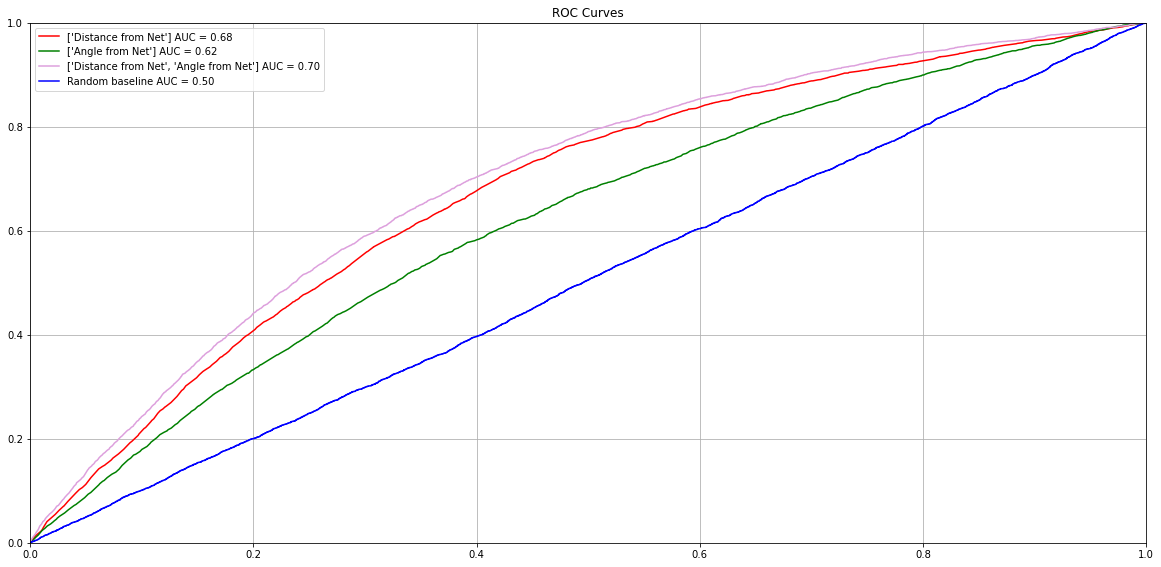

[22:57:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


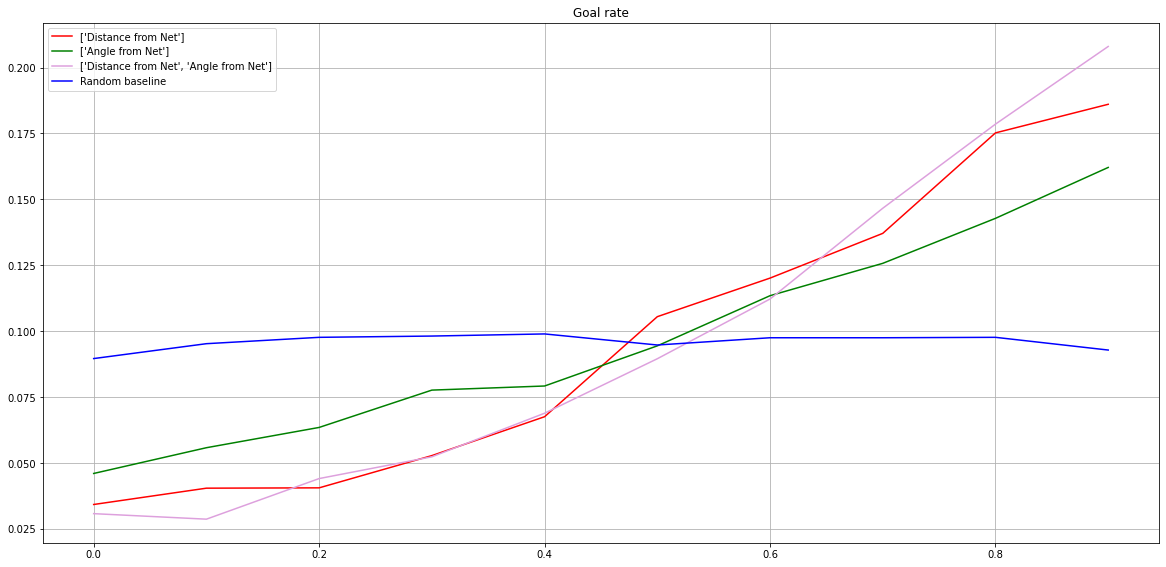

[22:57:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


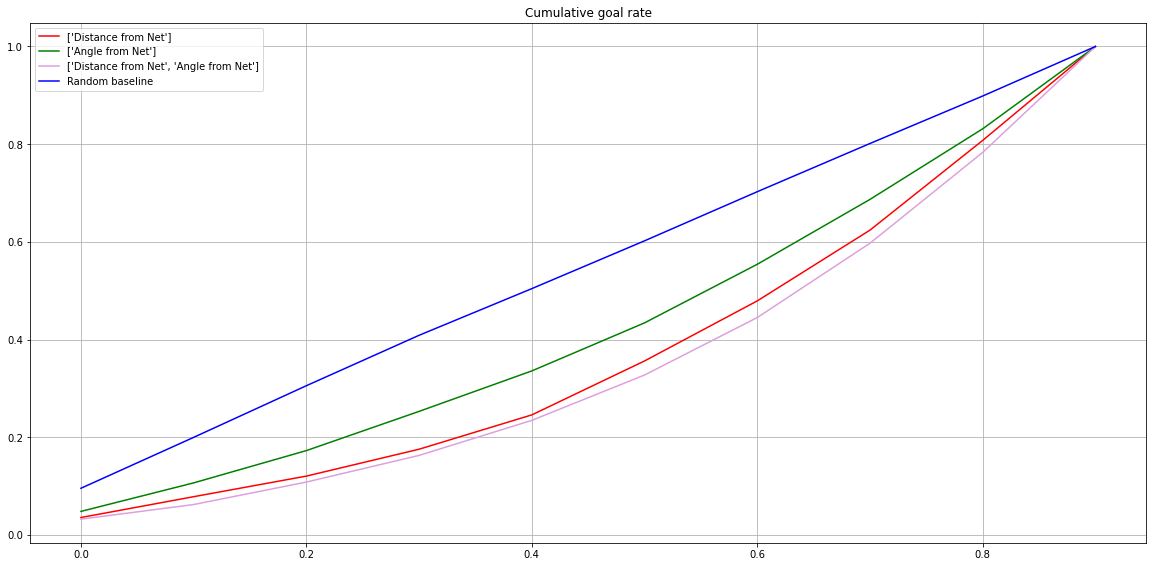

[22:57:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


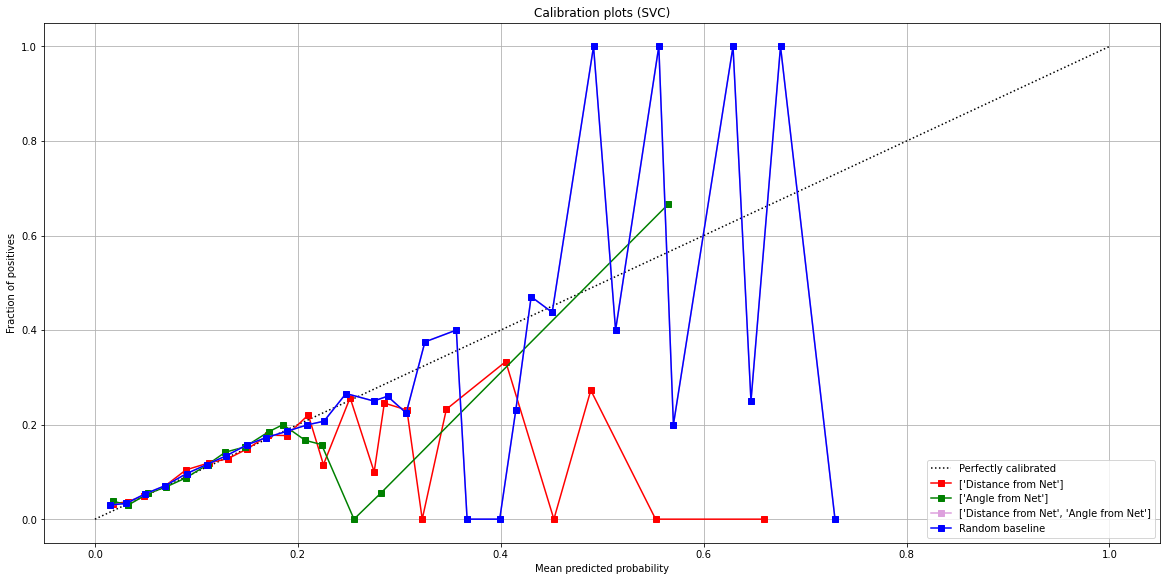

In [5]:
X,y = read_dataset()
plot_models(X, y, 'xgb')

[22:57:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


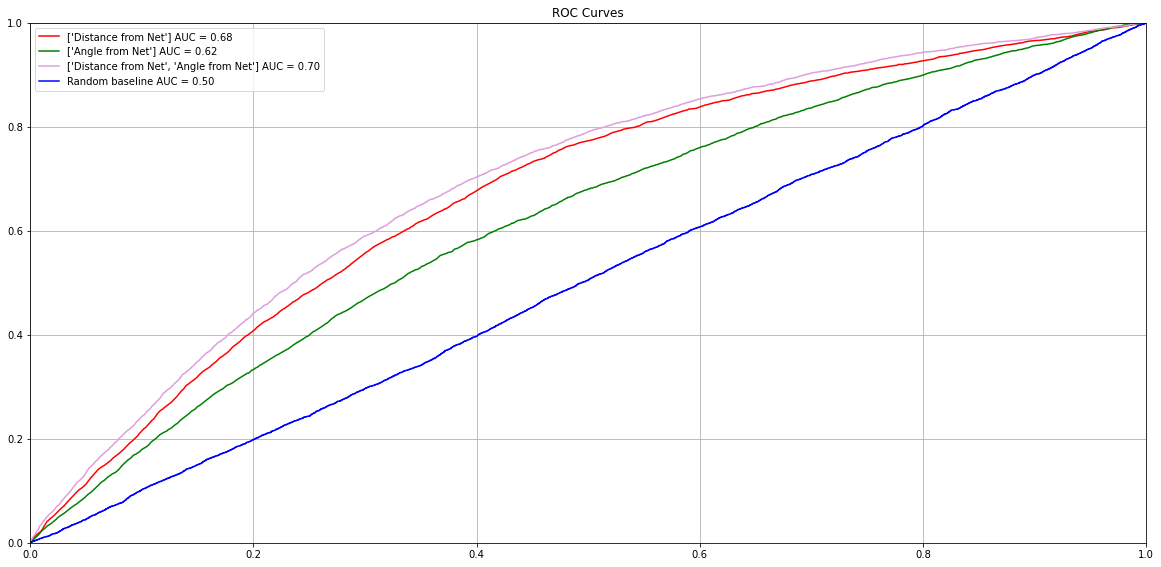

[22:58:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


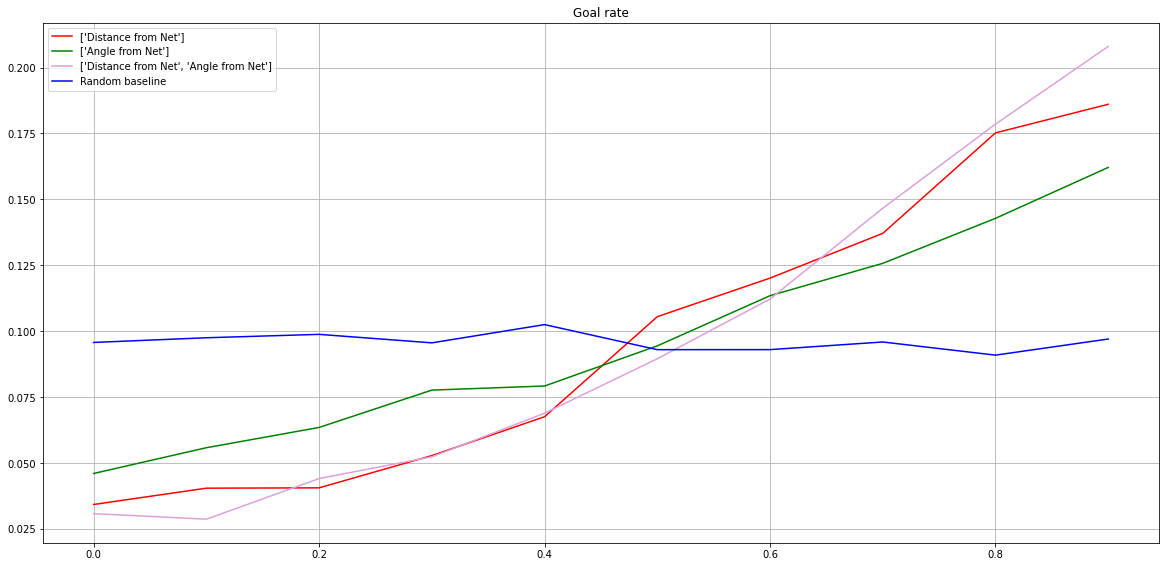

[22:58:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


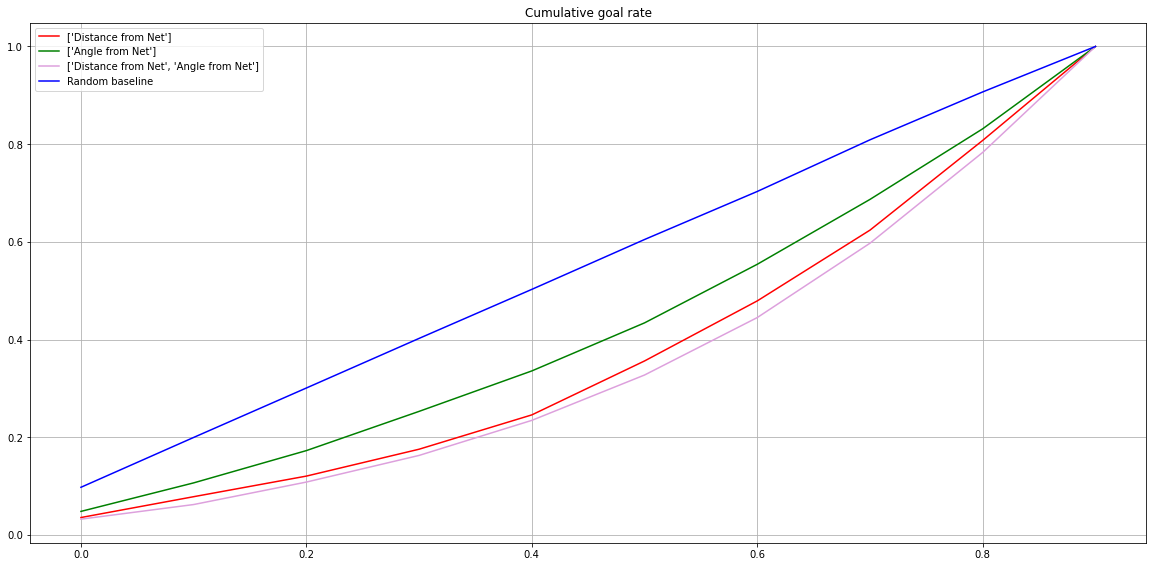

[22:58:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


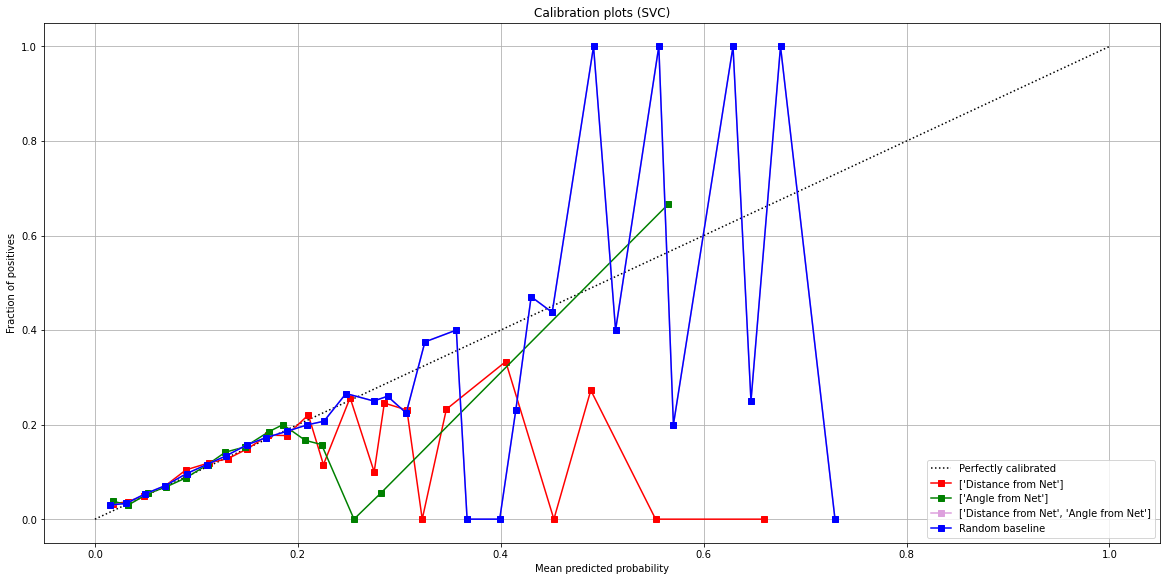

In [6]:
plot_models(X, y, 'xgb', features=['Angle from Net'])

[22:58:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


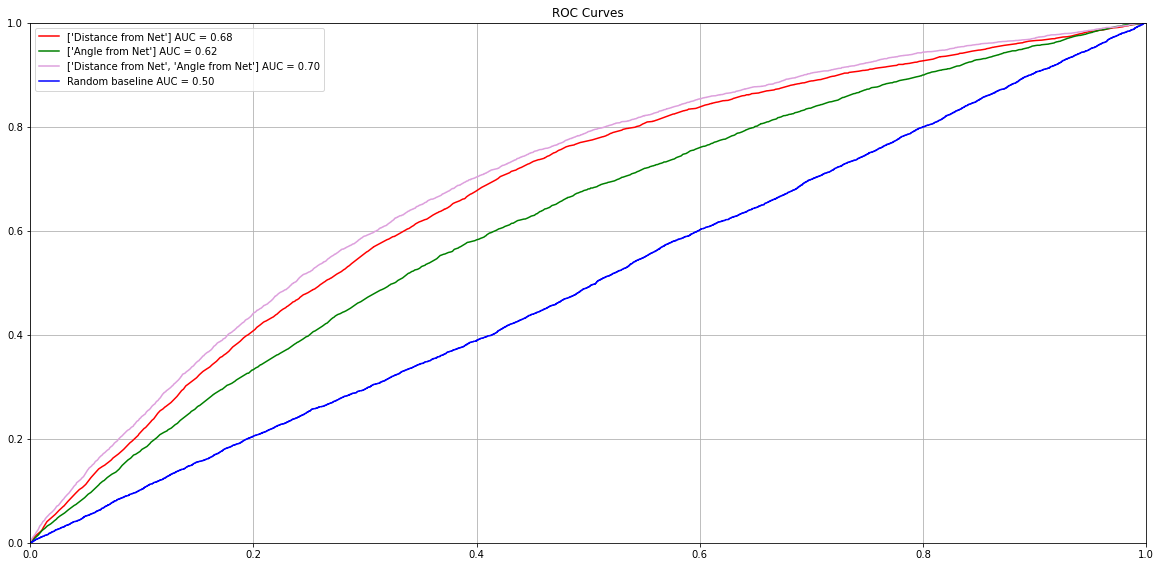

[22:58:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


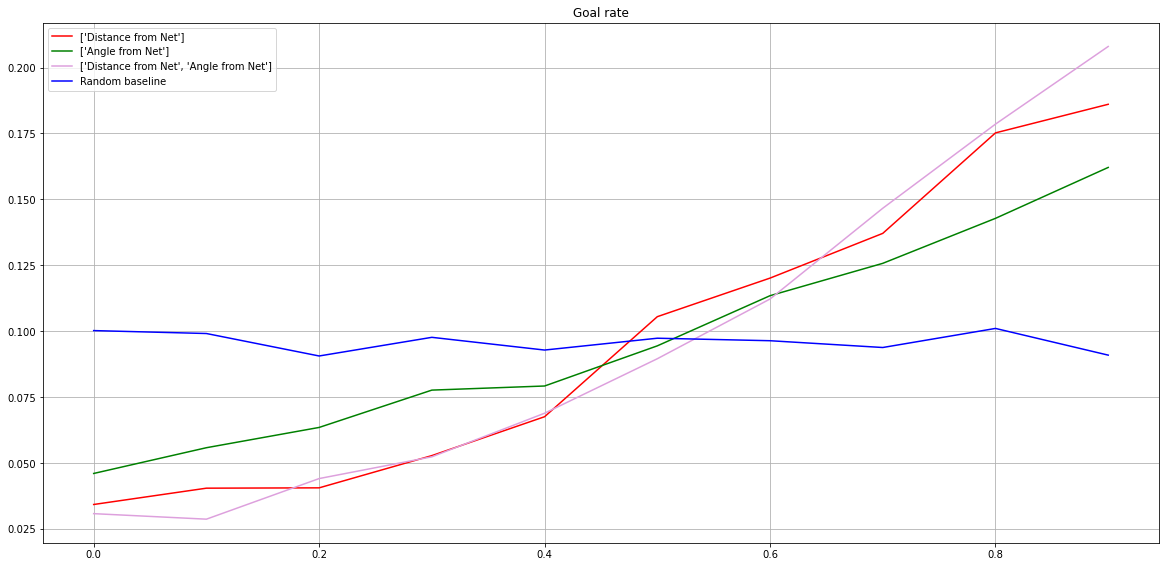

[22:59:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


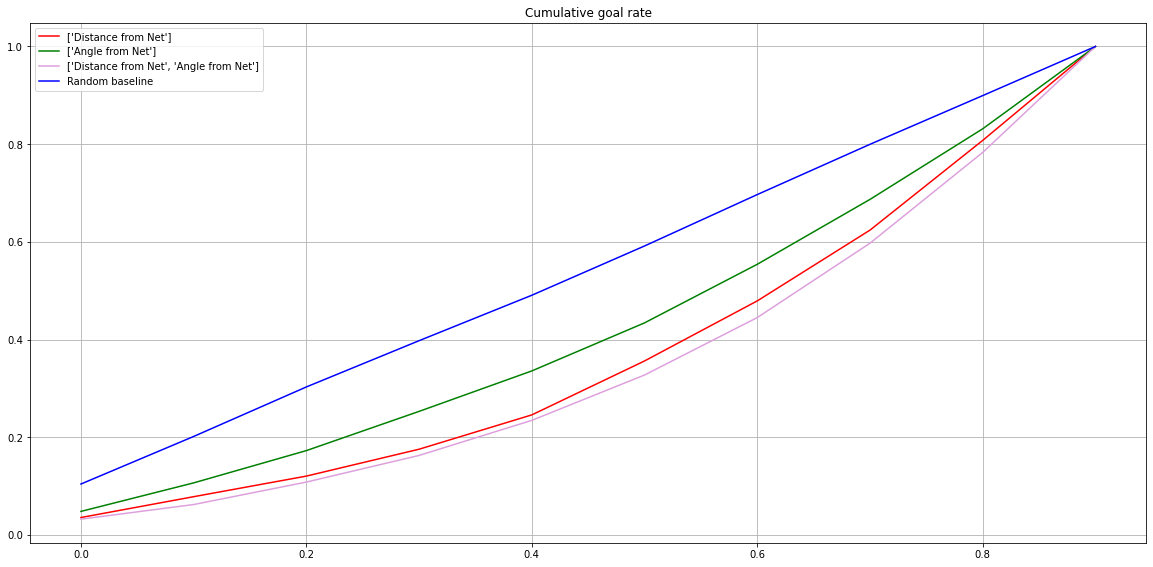

[22:59:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


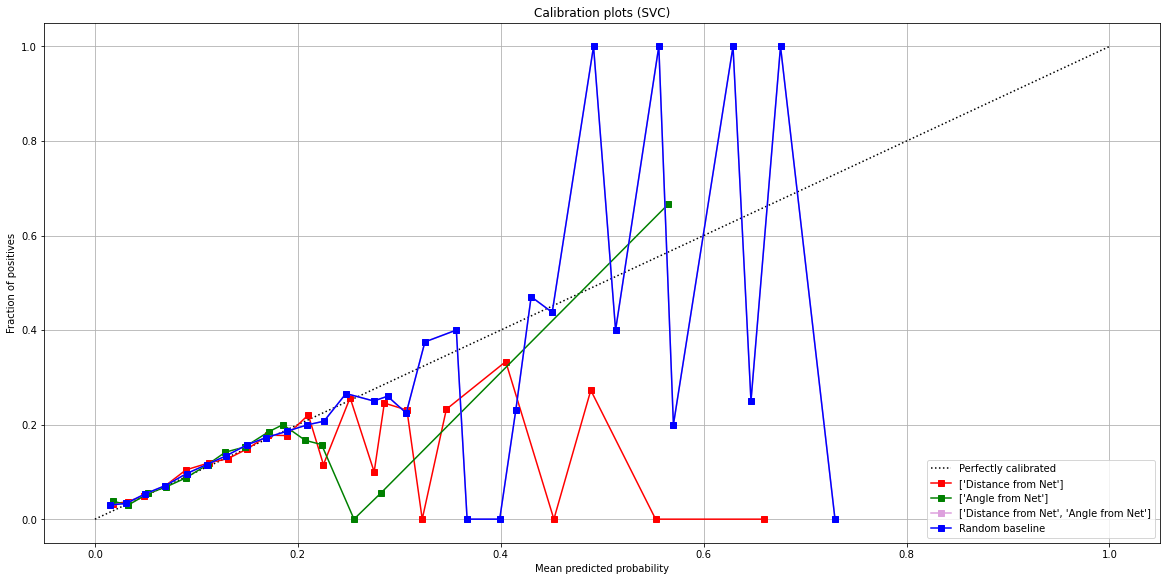

In [7]:
plot_models(X, y, 'xgb', features=['Distance from Net', 'Angle from Net'])

In [9]:
#########################################################
# 5.2 XGBoost + hyperparameter tuning
# ref:
# - https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d
#########################################################

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

def train2(X, y, features=['Distance from Net']):
    
    X,y = read_dataset()

    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[features],
                                                        y,
                                                        test_size=0.20,
                                                        random_state=50)

    # Fit model no training data
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    #setting grid of selected parameters for iteration
    param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
    
    #dictionary for collecting results
    results_dict = {}

    #obtaining default parameters by calling .fit() to XGBoost model instance
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                              booster='gbtree',
                              eval_metric='auc',
                              tree_method='hist',
                              grow_policy='lossguide',
                              use_label_encoder=False)
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
    clf0.fit(X_train, y_train.values.ravel())

    #results dataframe
    df = pd.DataFrame(clf0.cv_results_)

    #predictions - inputs to confusion matrix
    train_predictions = clf0.predict(X_train)
    test_predictions = clf0.predict(X_test)
    unseen_predictions = clf0.predict(df_test.iloc[:,1:])

    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)

    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
    f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)

    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])
    unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf0.predict_proba(df_test.iloc[:,1:])[:,1])

    #best parameters
    bp = clf0.best_params_

    #storing computed values in results dictionary
    results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                             'classifier': deepcopy(clf0),
                             'cv_results': df.copy(),
                             'cfm_train': cfm_train,
                             'cfm_test': cfm_test,
                             'cfm_unseen': cfm_unseen,
                             'train_accuracy': accs_train,
                             'test_accuracy': accs_test,
                             'unseen_accuracy': accs_unseen,
                             'train F1-score label 1': f1s_train_p1,
                             'train F1-score label 0': f1s_train_p0,
                             'test F1-score label 1': f1s_test_p1,
                             'test F1-score label 0': f1s_test_p0,
                             'unseen F1-score label 1': f1s_unseen_p1,
                             'unseen F1-score label 0': f1s_unseen_p0,
                             'test roc auc score': test_ras,
                             'unseen roc auc score': unseen_ras,
                             'best_params': bp}
    
    print(results_dict)

In [10]:
train2(X, y)

[02:21:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


NameError: name 'df_test' is not defined